<div class = 'alert alert-info'> 
    <h1>Austin BCycle Station Analysis</h1>
    <p> Data is pulled from data.world in March 2020, and collected from weatherunderground and AustinBcycle in April-May 2016</p>
    <h2>Primary Goal</h2>
    <p>A cycle station can either be categorized as <b>active</b> or <b>inactive</b> depending on the number of bikes or docks available at a given time. When a station is considered INACTIVE, it is in one of two possible states:</p>
        <ol>
            <li>The station has no available bikes to check out (cannot start a ride).</li>
            <li>The station has no available docks to return a bike to (cannot end a ride)</li>
    </ol>
    <p>If neither of these conditions are true, the station is considered ACTIVE.
    </p>
    <p> In order to maximize customer satisfaction, inactive stations should be minimized as much as possible. To accomplish this goal, we need to identify stations which become inactive most frequently, and make suggestions to mitigate this effect.</p> 
    
<h2>Part 1 ‑ Data Cleaning & Exploratory data analysis</h2>

<h3>Objectives<br></h3>
<p>The Bcycle data was originally collected every 5 minutes from the Austin Bcycle website. I am going to aggregate these bike and dock counts based on daily and 1 hour time intervals, and then visualize and describe the resulting station activity. Next, I will report and illustrate important features of the activity, such as individual station location variability and weather patterns. As interesting patterns emerge, statistical tests will be done to investigate correlations. </p>
</div>

In [168]:
# package imports
import pandas as pd
import geopandas as gpd
import numpy as np 

# visualization imports 
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.geometry as geo
import folium
%matplotlib inline

# modeling imports 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import log_loss

In [20]:
# import tables
bikes_raw = pd.read_csv('https://query.data.world/s/cxz3gqutkqnjvkdjnnjvlhouesfzw3', parse_dates=True)
stations_raw = pd.read_csv('https://query.data.world/s/yduqgj4j6ph5uicv2ukznkmy5rpey2')
weather_raw = pd.read_csv('https://query.data.world/s/7zgro4lpydwuiqikl5oigum4jrw6wi', parse_dates=True)

,Total,Percent
Events,29,47.540984
WindDirDegrees,0,0.000000
Max Sea Level PressureIn,0,0.000000
Max TemperatureF,0,0.000000
Mean TemperatureF,0,0.000000


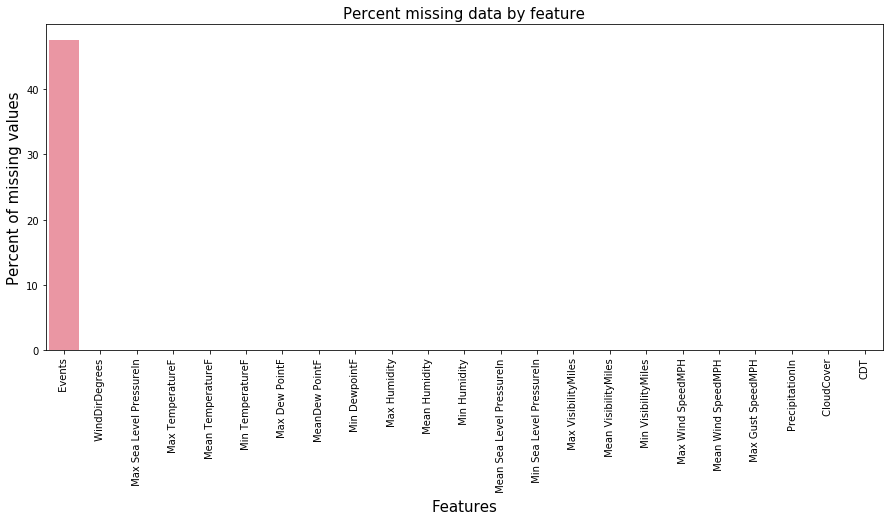

In [21]:
# before delving into statistics, check the null values 
total = weather_raw.isnull().sum().sort_values(ascending=False)
percent = (weather_raw.isnull().sum()/weather_raw.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

<div class="alert alert-warning">
    Since the weather data was originally sampled from weather underground, I am able to fill the missing values with accurate event data from the given days.
</div>

In [22]:
# filled missing values by hand in excel... reupload cleaned version
weather_clean = pd.read_csv('weather.csv')

# convert cdt column to datetime objects and rename it 
weather_clean['CDT'] = pd.to_datetime(weather_clean['CDT'], infer_datetime_format=True)
weather_clean = weather_clean.rename(columns={"CDT":"date"})

In [23]:
# delete datetime column from stations
stations_clean = stations_raw.copy()
stations_clean.drop('datetime', axis=1, inplace=True)
#stations_clean.head()

In [24]:
# create a column to hold the location object
crs = {'init': 'EPSG:4326'}
location = [geo.Point(xy) for xy in zip(stations_clean["lat"], stations_clean['lon'])]
stations_geo = gpd.GeoDataFrame(stations_clean, crs = crs, geometry=location)
#stations_geo.head()

/Users/jillrosow/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [25]:
# convert date column to datetime 
bikes_clean = bikes_raw.copy()
bikes_clean['datetime'] = pd.to_datetime(bikes_clean['datetime'])

# add a column to to indicate station capacity
bikes_clean['station_capacity'] = [x + y for x,y in zip(bikes_clean.bikes, bikes_clean.docks)]

# add a columns to bikes to indicate if a station is full or empty; full=docks=0, empty=bikes=0
bikes_clean['empty'] = (bikes_clean.bikes == 0).astype('int64')
bikes_clean['full'] = (bikes_clean.docks == 0).astype('int64')

bikes_clean['temp'] = bikes_clean["empty"] + bikes_clean['full']

# add new column for active status
bikes_clean['active_status'] = [1 if x == 0 else 0 for x in bikes_clean['temp']]

# drop the temporary column 
bikes_clean.drop('temp', axis=1, inplace=True)

In [26]:
# merge stations and bikes 
bikes_stations = bikes_clean.merge(stations_geo, on='station_id')
bikes_stations.set_index(['station_id', 'name', 'datetime'], inplace=True)

In [30]:
# split the data into active and inactive stations 
active = bikes_stations[bikes_stations.active_status == 1]
inactive = bikes_stations[bikes_stations.active_status == 0]

In [31]:
# function for resampling
def resamp(df, freq):
    level_values = df.index.get_level_values
    return (df.groupby([level_values(i) for i in [0,1]] + 
                                             [pd.Grouper(freq=freq, level=-1)]).count())

In [36]:
# grab columns for graphing
station_inactivity = inactive.filter(['empty','full','active_status'], axis=1)
bikes_stations.reset_index(inplace=True)
station_activity = bikes_stations[['empty', 'full', 'active_status', 'name']]

daily_inactive = resamp(station_inactivity, 'D')
daily_inactive = daily_inactive.reset_index(level=[0, 1]) # undo multi index for ease
daily_inactive["day_of_week"] = daily_inactive.index.day_name()

daily_inactive_sums = pd.DataFrame(daily_inactive.groupby('day_of_week')['active_status'].count())
reorder_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_inactive_sums = daily_inactive_sums.reindex(reorder_list)

[Text(0.0, 0, 'Monday'),
 Text(0.2, 0, 'Tuesday'),
 Text(0.4, 0, 'Wednesday'),
 Text(0.6000000000000001, 0, 'Thursday'),
 Text(0.8, 0, 'Friday'),
 Text(1.0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

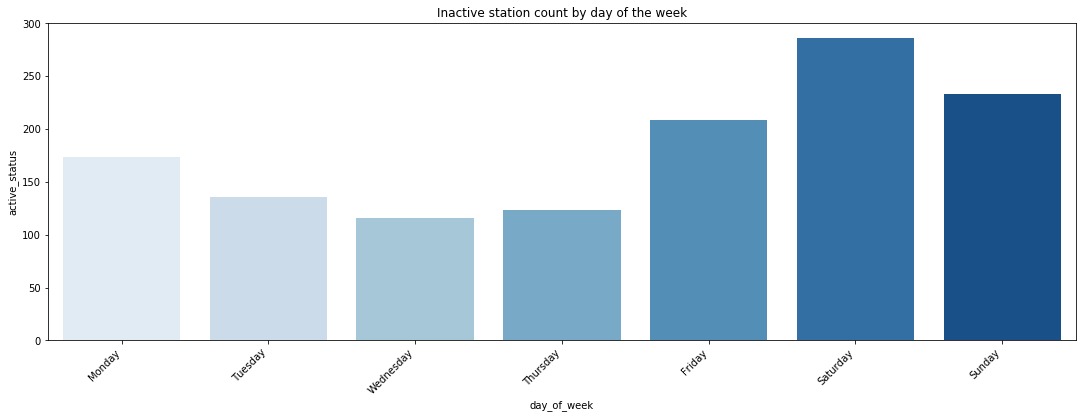

In [37]:
# visualize the entirety of the data 
fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
chart = plt.xlabel("Day of the week")
chart = plt.ylabel("Number of inactive stations")
chart = plt.title("Inactive station count by day of the week")
chart = sns.barplot(daily_inactive_sums.index, daily_inactive_sums.active_status, palette="Blues")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

<div class="alert alert-success">
    This graph shows that stations are inactive most often on weekends, especially Saturdays. 

</div>

In [38]:
# do a line graph with hue = week day and x axis = hour 
hourly_inactive = resamp(station_inactivity, 'H')
hourly_inactive = hourly_inactive.reset_index(level=[0, 1]) # undo multi index for ease
hourly_inactive["day_of_week"] = hourly_inactive.index.day_name()
hourly_inactive['hour'] = [time.hour + 1 for time in hourly_inactive.index]

# reorder by day of week 
hourly_inactive = pd.pivot_table(hourly_inactive, values = 'active_status', index = 'day_of_week', columns='hour', aggfunc='count')
hourly_inactive = hourly_inactive.reindex(reorder_list)

# stack
avg_hourly_inactive = hourly_inactive.stack(level=['hour'])
# name the stack
avg_hourly_inactive.name = 'avg_num_inactives'
avg_hourly_inactive_df = avg_hourly_inactive.reset_index()
#hourly_inactive_sums = pd.DataFrame(hourly_inactive.groupby(hourly_inactive.index)['active_status'].count())
#hourly_inactive_sums = hourly_inactive_sums.reindex(reorder_list)

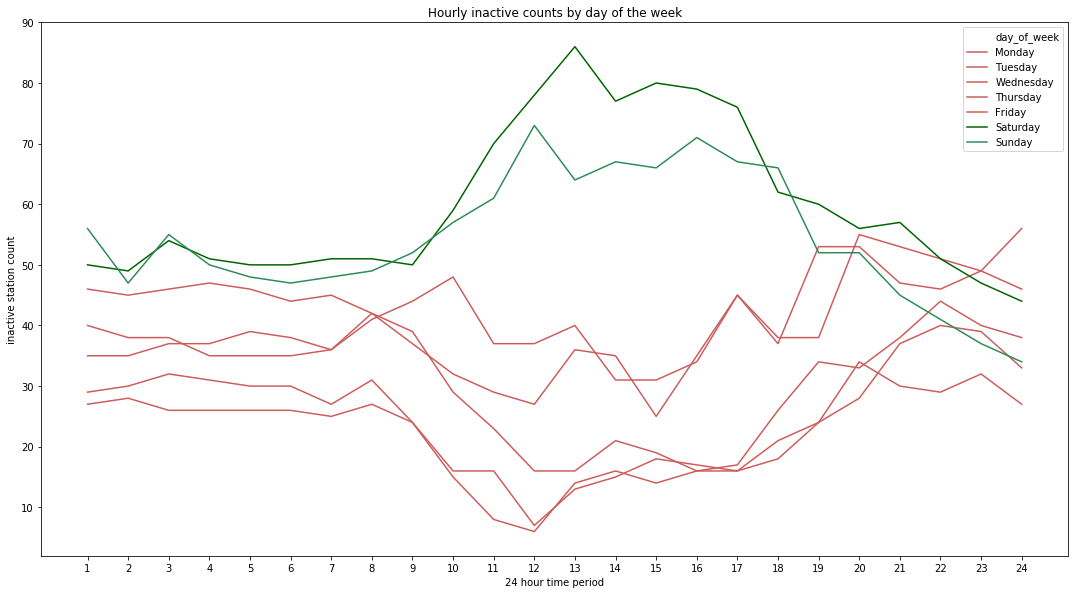

In [39]:
# graph set up
fig, ax = plt.subplots(figsize = (15,8))
plt.tight_layout()
_ = plt.xticks([x for x in range(1, 25)])
_ = sns.lineplot(x="hour", y="avg_num_inactives", data=avg_hourly_inactive_df, hue="day_of_week", palette=['indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'darkgreen', 'seagreen'])
_ = plt.title("Hourly inactive counts by day of the week")
_ = plt.xlabel("24 hour time period")
_ = plt.ylabel('inactive station count')

<div class="alert alert-success">
  <p>  After separating by hour, we can see that during weekends (highligted in green), stations are most likely to be inactive from around 9am to 7pm. This is likely attributable to bikers taking leisure rides during the daytime on weekends, which is common around Town Lake in Austin. </p>
   <p>Weekdays (highlighted in red), show an opposite pattern: station inactivity levels are higher in the morning and evening than during the daytime. This is probably due to users taking trips to commute to work.</p>
</div>

In [40]:
#station_activity = bikes_stations.filter(['empty','full','active_status'], axis=1)
inactive_counts = station_inactivity.groupby('name')['active_status', 'empty', 'full'].count()
inactive_counts.sort_values(by=['active_status'], ascending=False, inplace=True)

In [41]:
# want to look at the percentage of time each station is inactive
# add a column for percent of time that the station is inactive 
all_counts = station_activity.groupby('name')['active_status', 'empty', 'full'].count()
all_counts.sort_values(by=['active_status'], ascending=False, inplace=True)

In [42]:
percent_inactive = pd.DataFrame(inactive_counts.active_status / all_counts.active_status * 100)
percent_inactive.sort_values(by=['active_status'], ascending=False, inplace=True)

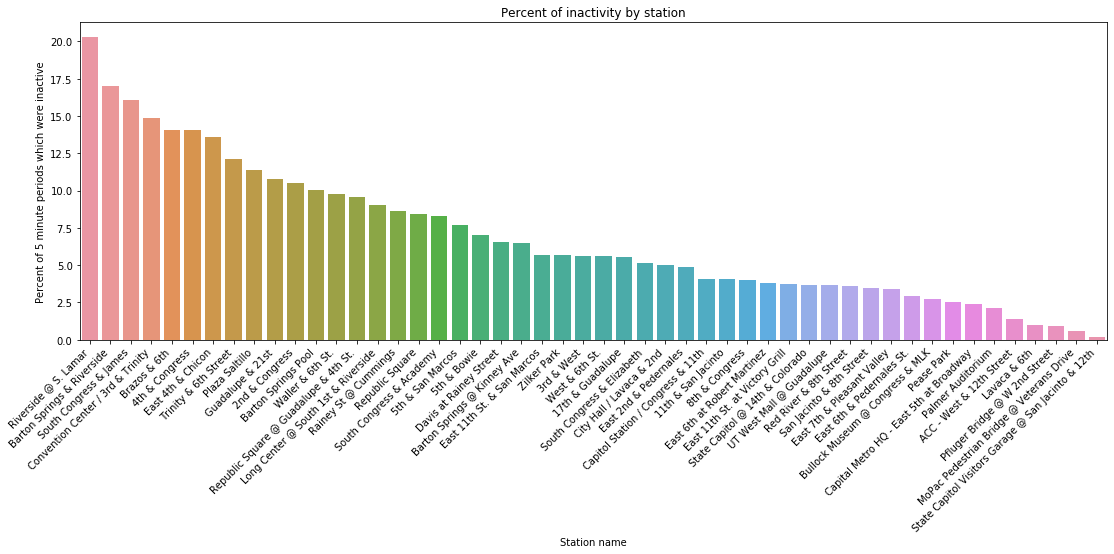

In [43]:
# visualize the entirety of the data 
fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
chart = sns.barplot(percent_inactive.index, percent_inactive.active_status)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = plt.xlabel("Station name")
chart = plt.ylabel("Percent of 5 minute periods which were inactive")
chart = plt.title("Percent of inactivity by station")

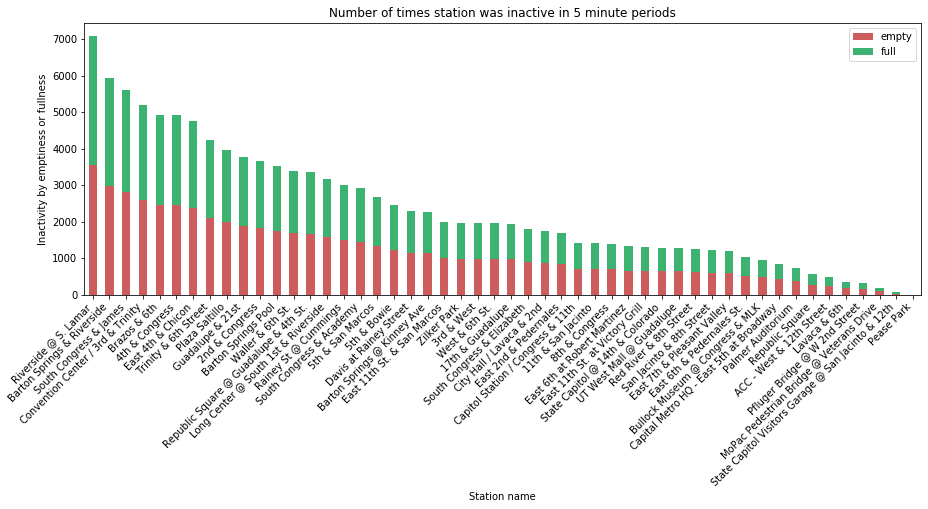

In [44]:
df = inactive_counts.drop('active_status', axis=1)
_ = df.plot.bar(stacked=True, figsize=(15, 5), color=['indianred', 'mediumseagreen'])
_.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.xlabel("Station name")
_ = plt.ylabel("Inactivity by emptiness or fullness")
_ = plt.title("Number of times station was inactive in 5 minute periods")

<div class="alert alert-success">
  <p>Looking now at data variation by station/location, we can see the stations that tend to be inactive more often than others. In our case, the stations that became inactive the most are centered around downtown areas, tourist attractions, and parks.</p>
    <p>The reason for inactivity (empty or full) is not heavily influenced by the location.
    </p>
</div>

In [45]:
# resample the weather data before merging 
weather_clean.set_index('date', inplace=True)
weather_clean = weather_clean.resample('5Min').fillna(method='ffill')
weather_clean.reset_index()

,date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees
0,2016-04-01 00:00:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
1,2016-04-01 00:05:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
2,2016-04-01 00:10:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
3,2016-04-01 00:15:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
4,2016-04-01 00:20:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
5,2016-04-01 00:25:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
6,2016-04-01 00:30:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
7,2016-04-01 00:35:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
8,2016-04-01 00:40:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22
9,2016-04-01 00:45:00,66,59,51,52,45,38,72,57,42,...,10,9,2,21,8,37,0.34,5,Cloudy,22


In [48]:
# go back to original data frame and rename date to merge with weather
data = bikes_stations.reset_index()
data.rename(columns={'datetime': 'date'}, inplace=True)
data.set_index('date', inplace=True)

# merge with weather 
all_data = data.join(weather_clean, on='date')


In [49]:
dummy = station_inactivity.reset_index(level=[0,1,2])
#dummy = dummy.groupby(['datetime', 'name'])['empty', 'full', 'active_status'].count()
#dummy = dummy.reset_index(level=[0,1])

In [50]:
# want to plot number of stations that are inactive at each temperature 
# group by date, count the number that are inactive, and plot against the weather columns?
dummy = pd.DataFrame(dummy.groupby('datetime').active_status.count())
dummy = dummy.reset_index()

In [51]:
windData = all_data[[' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH']]
winds = dummy.merge(windData, left_on='datetime', right_on='date')

precip = all_data[['PrecipitationIn']]
precips = dummy.merge(precip, left_on='datetime', right_on='date')


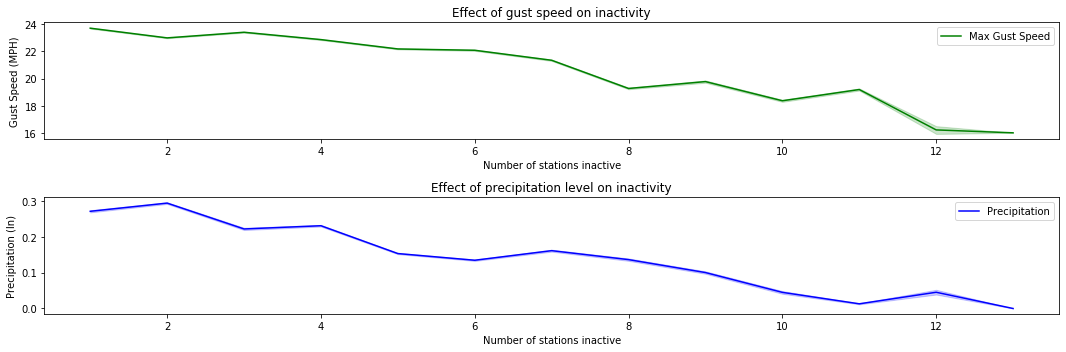

In [52]:
# wind and precipitation plots
_ = plt.subplots(figsize=(15, 5))
_ = plt.tight_layout()



_ = plt.subplot(2, 1, 1)
_ = sns.lineplot(winds.active_status, winds[' Max Gust SpeedMPH'], color="green", label="Max Gust Speed")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Gust Speed (MPH)")
_ = plt.title("Effect of gust speed on inactivity")
_ = plt.legend()

_ = plt.subplot(2, 1, 2)
_ = sns.lineplot(precips.active_status, precips['PrecipitationIn'], color="blue", label="Precipitation")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Precipitation (In)")
_ = plt.title("Effect of precipitation level on inactivity")
_ = plt.legend()

_ = plt.tight_layout()

<div class="alert alert-success">
  <p>Expectedly for biking, as the wind speed decreases, the number of stations inactive increases.</p>
    
</div>

<div class="alert alert-success">
  <p>Also non surprisingly, when it rained less inches in Austin, the number of stations inactive increases. This is probably due to the fact that riders typically ride more on sunny days then on rainy days.</p>
    
</div>

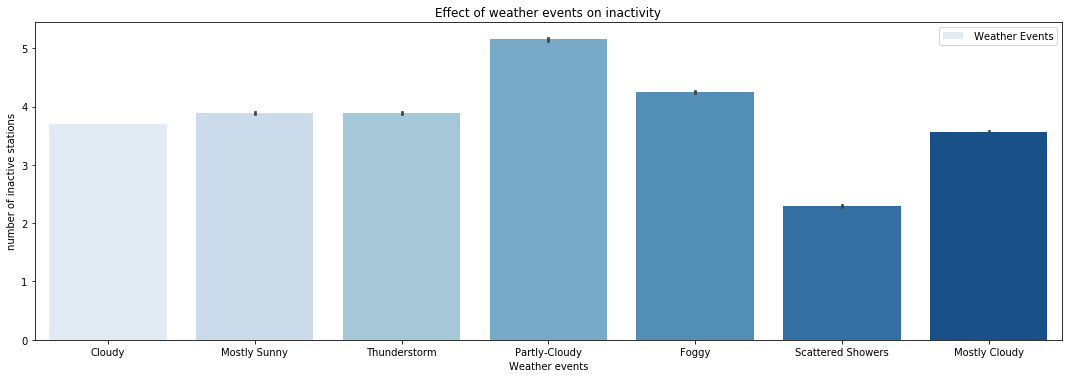

In [53]:
# cloud cover
event = all_data[[' Events']]
events = dummy.merge(event, left_on='datetime', right_on='date')
events.sort_values(by=['active_status'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.barplot(events[' Events'], events.active_status, palette="Blues", label=" Weather Events")
_ = plt.xlabel("Weather events")
_ = plt.ylabel("number of inactive stations")
_ = plt.title("Effect of weather events on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>As expected from the precipitation graph, the least amount of stations are inactive during scattered showers days.</p>
    <p> Though I predicted the mostly sunny days would show highest levels of inactivity, it is actually partly-cloudy. I believe this is probably due to the fact that more time periods during the recorded months were partly-cloudy days than were sunny. </p>
</div>

In [54]:
# grab inactive labels with station name and datetime stamp
inactive_labels = inactive.copy()
inactive_labels = inactive_labels[['active_status']]

# grab active labels with station name and datetime stamp 
active_labels = active.copy()
active_labels = active_labels[['active_status']]

In [55]:
# put the labels all in one place and sort by datetime
activity_labels = pd.concat([inactive_labels,active_labels])
activity_labels.sort_values(by='datetime', inplace=True)

# only want label, station, active status
activity_labels.reset_index(inplace=True)
activity_labels.drop('station_id', axis=1, inplace=True)

In [56]:
# grab the weather data I want to evaluate 
weather_red = weather_clean[['Mean TemperatureF', 'MeanDew PointF', ' Mean Humidity', ' Mean Sea Level PressureIn',
                             ' Mean VisibilityMiles', ' Mean Wind SpeedMPH', 'PrecipitationIn', ' CloudCover', ' Events']]
weather_red.columns = ['meanTemp', 'meanDewPoint', 'meanHumidity', 'meanSeaLevelPressure', 'meanVisibility',
                   'meanWindSpeed', 'precipitation', 'cloudCover', 'events']
weather_red.reset_index(inplace=True)

In [57]:
# same thing for inactivity for consistency 
# want row index to be the day, column index to be the active status, and values to be the mean temp 
inactive_labels.reset_index(inplace=True)
inactive_labels.set_index('datetime', inplace=True)
inactive_labels['day'] = inactive_labels.index.dayofweek # monday = 0, sunday = 6
inactive_labels.sort_values('day')
inactive_labels.reset_index()

# i want the normal activity status back in... merge with activity labels 
df_inactive = weather_red.merge(inactive_labels, left_on='date', right_on = inactive_labels.index)

# create dataframes for heat maps
temp_inactive = pd.pivot_table(df_inactive, columns='meanTemp', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
dew_inactive = pd.pivot_table(df_inactive, columns='meanDewPoint', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
hum_inactive = pd.pivot_table(df_inactive, columns='meanHumidity', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
vis_inactive = pd.pivot_table(df_inactive, columns='meanVisibility', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
wind_inactive = pd.pivot_table(df_inactive, columns='meanWindSpeed', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
precip_inactive = pd.pivot_table(df_inactive, columns='precipitation', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
cloud_inactive = pd.pivot_table(df_inactive, columns='cloudCover', index='name', values='active_status', aggfunc='count',
                            fill_value = 0)
events_inactive = pd.pivot_table(df_inactive, columns='events', index='name', values='active_status', aggfunc='count',
                                 fill_value=0)

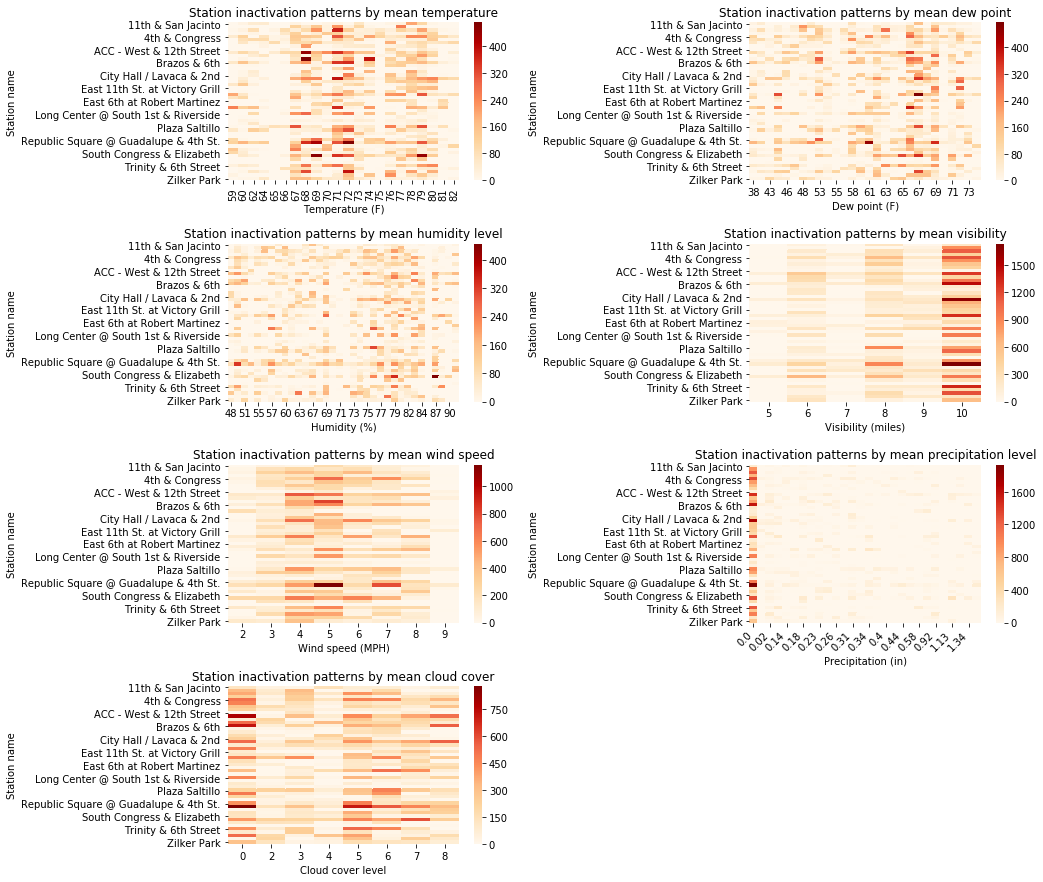

In [58]:
_ = plt.subplots(figsize=(12,12))
_ = plt.tight_layout()
_ = plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.4)

_ = plt.subplot(4, 2, 1)
_ = sns.heatmap(temp_inactive, cmap='OrRd')
_.set_xticklabels(_.get_xticklabels(), rotation=90, horizontalalignment='center')
_ = plt.title('Station inactivation patterns by mean temperature')
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('Station name')


_ = plt.subplot(4, 2, 2)
_ = sns.heatmap(dew_inactive, cmap='OrRd')
_.set_xticklabels(_.get_xticklabels(), rotation=0, horizontalalignment='center')
_ = plt.title('Station inactivation patterns by mean dew point')
_ = plt.xlabel('Dew point (F)')
_ = plt.ylabel('Station name')


_ = plt.subplot(4,2,3)
_ = sns.heatmap(hum_inactive, cmap='OrRd')
_ = plt.title('Station inactivation patterns by mean humidity level')
_ = plt.xlabel('Humidity (%)')
_ = plt.ylabel('Station name')

_ = plt.subplot(4,2,4)
_ = sns.heatmap(vis_inactive, cmap='OrRd')
_ = plt.title('Station inactivation patterns by mean visibility')
_ = plt.xlabel('Visibility (miles)')
_ = plt.ylabel('Station name')

_ = plt.subplot(4,2,5)
_ = sns.heatmap(wind_inactive, cmap='OrRd')
_ = plt.title('Station inactivation patterns by mean wind speed')
_ = plt.xlabel('Wind speed (MPH)')
_ = plt.ylabel('Station name')

_ = plt.subplot(4,2,6)
_ = sns.heatmap(precip_inactive, cmap='OrRd')
_.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.title('Station inactivation patterns by mean precipitation level')
_ = plt.xlabel('Precipitation (in)')
_ = plt.ylabel('Station name')


_ = plt.subplot(4,2,7)
_ = sns.heatmap(cloud_inactive, cmap='OrRd')
_ = plt.title('Station inactivation patterns by mean cloud cover')
_ = plt.xlabel('Cloud cover level')
_ = plt.ylabel('Station name')

<div class="alert alert-success">
    <h3>Temperature</h3>
    <p>We see stations go inactive most frequently when temperatures are at a moderate level, about 67 - 80 degrees. This makes sense, as biking is most enjoyable when it is comfortable outside. This correlation is strongest around 71 degrees.</p>
    <h3>Dew Point</h3>
    <p>The correlations seen here are weaker in magnitude, but it can be seen that the overall stations go inactive the most with dew points around 65-69 degrees.</p>
    <h3>Humidity</h3>
    <p>Humidity shows a mostly weak correlation throughout stations, though a small increase in inactive stations can be seen around 70% humidity. This may be due to the corresponding average temperature at this level; perhaps 70% humidity correlates with 67-80 degrees in temperature, a factor which increases inactive stations (see below). Interestingly, almost no stations are inactive once humidity reach 85 degrees, indicating riders may prefer riding in weather below this threshold humidity.</p>
    <h3>Visibility</h3>
    <p>A clear pattern is seen in which stations are inactive more often during high visibility time periods. This observation aligns with my predications, since low visibility generally makes biking more difficult, stressful, and cumbersome.</p>
    <h3>Wind speed</h3>
    <p>Stations are shown inactive most frequently in the 4-5 mph wind speed range. I hypothesize there are two possibilities for this result: drivers prefer a small amount of wind to propel their speed, or data is sparse for this feature and concentrated around these values. </p>
    <h3>Precipitation</h3>
    <p>It is important to note that precipitation data is sparse (see below). However, it is still relevant to note the heavy increase in inactive stations when no rain was recorded. This is logical, as biking becomes much more dangerous and less enjoyable when roads are wet.</p>
    <h3>Cloud cover</h3>
    <p>The correlation here seems to be pretty weak, but still, a notable increase in active station count is seen when cloud cover is 0, or the skies are clear. </p>
</div>

In [63]:
active_labels.reset_index(inplace=True)

In [66]:
df_active = weather_red.merge(active_labels, left_on='date', right_on = active_labels.datetime)


In [67]:
df_all = pd.concat([df_active,df_inactive], sort=True)
df_all.sort_values('date', inplace=True)

Pearson correlation coefficient: 0.35


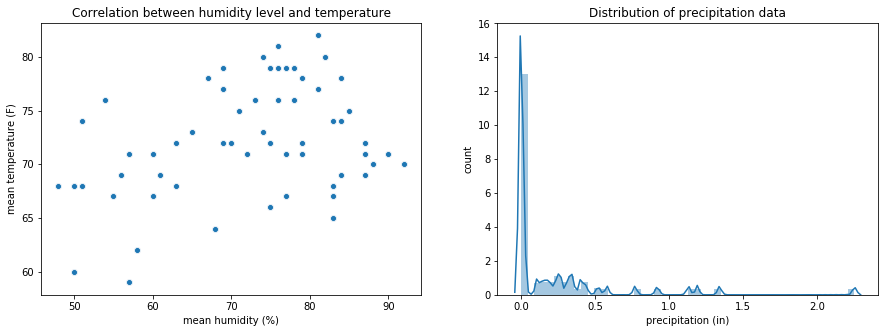

In [68]:
_ = plt.subplots(figsize=(15,5))
_ = plt.subplot(1,2,1)
_ = sns.scatterplot(x='meanHumidity', y='meanTemp', data=df_all)
_ = plt.title('Correlation between humidity level and temperature')
_ = plt.xlabel('mean humidity (%)')
_ = plt.ylabel('mean temperature (F)')
print("Pearson correlation coefficient:", '{:0.2f}'.format(df_all.meanHumidity.corr(df_all.meanTemp)))
_ = plt.subplot(1,2,2)
_ = sns.distplot(df_all.precipitation)
_ = plt.title('Distribution of precipitation data')
_ = plt.xlabel('precipitation (in)')
_ = plt.ylabel('count')

<div class="alert alert-success">
    <ul>
    <li><p>To make sense of the humidity heat map above, I investigated the relationship between humidity and temperature both visually, in a scatter plot, and numerically, with the pearson coefficient of correlation. It turns out, our data does show a relationship between around 70% humidity and the sweet spot for biking temperature. However, it is important to note that this correlation is weak, with the r value equal to 0.35.</p></li>
    <li><p>To demonstrate uncover a potential bias in the precipitation data, I plotted a distribution graph of this feature. As expected, a majority of the data is from 0 precipitation days, so the heat map above is probably not a good representation of the variables' true relationship.</p></li>
    </ul>
</div>

In [73]:
station_labels = stations_clean[['station_id', 'name']]
station_labels.reset_index(inplace=True)

In [75]:
# add the station capacity 
capacity = bikes_clean[['station_id', 'station_capacity']]
capacity.drop_duplicates(subset='station_id', keep='first', inplace=True)
capacity.set_index('station_id')

# add the lat and lon
cap_loc = capacity.merge(stations_geo[['station_id', 'lat', 'lon']], on='station_id')
cap_loc = cap_loc.merge(station_labels, on='station_id')
cap_loc.set_index('name', inplace=True)


# scale the capacities
cap_loc['cap_std'] = cap_loc['station_capacity'] / cap_loc['station_capacity'].max()

/Users/jillrosow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
# create the base map
atx = folium.Map(location=[30.28900, -97.74186], zoom_start=13, tiles="Stamen Toner", titles='Austin Bcycle Station Map', attr='attribution')
atx.save('atx.html')

# add the stations
for station in cap_loc.index:
    if cap_loc.loc[(station, 'station_capacity')] in [15, 16, 17, 18, 19]:
        c = '#fc3003'
    else:
        c = '#3186cc'
    folium.CircleMarker(
        location=[cap_loc.loc[(station, 'lat')], cap_loc.loc[(station, 'lon')]],
        radius=cap_loc.loc[(station, 'cap_std')] * 12,
        popup=str(station) + "\nCapacity: " + str(cap_loc.loc[(station, 'station_capacity')]),
        color=c,
        fill=True,
        fill_color=c
    ).add_to(atx)

In [77]:
atx

In [78]:
print(cap_loc.station_capacity.describe())

count    50.000000
mean     12.620000
std       2.311374
min       9.000000
25%      11.000000
50%      13.000000
75%      13.000000
max      19.000000
Name: station_capacity, dtype: float64


<div class="alert alert-success">
    <ul>
    <li><p>The graph above shows both location and capacity information for the 50 stations. I chose to segment stations based on a capacity threhold value of 14 docks; red stations indicate those with capacities 15 and over, while blue show the remaining, smaller sized stations. This value was chosen for two reasons: first, 75% of stations had a capacity of at least 13, and second, the spread of the data permits the single 14 dock station to be lumped into the "smaller" category. To view the exact capacitiy count, simply click on any individual circle.</p></li>
    <li><p>This map shows four large stations being located along Lady Bird Lake. This aligns well with my predictions, since Lady Bird Lake has a 10 mile hike and bike trail around its perimeter.</p></li>
    <li><p>One other large station is shown, Capital Station / Congress & 11th. This is probably to the high volume of tourists visiting the capital building, since many other smaller stations exist downtown for work commuters.</p></li>
    <li><p> Overall, we see a greater density of stations in regions where the capacity is low and vice versa. </p></li>
    </ul>
</div>

In [79]:
percent_inactive.active_status.describe()

count    50.000000
mean      6.868211
std       4.712371
min       0.194319
25%       3.599188
50%       5.612391
75%       9.719996
max      20.260616
Name: active_status, dtype: float64

In [80]:
# create the base map
atx2 = folium.Map(location=[30.28900, -97.74186], zoom_start=13, tiles="Stamen Toner", titles='Austin Bcycle Station Map', attr='attribution')
atx2.save('atx2.html')

# add the stations
for station in cap_loc.index:
    if percent_inactive.loc[(station, 'active_status')] > 9.72:
        c = '#fc3003'
    else:
        c = '#53ab52'
    folium.CircleMarker(
        location=[cap_loc.loc[(station, 'lat')], cap_loc.loc[(station, 'lon')]],
        radius=percent_inactive.loc[(station, 'active_status')],
        popup=str(station) + "\n% Inactive: " + '{:6.2f}'.format(percent_inactive.loc[(station, 'active_status')],'.2f'),
        color=c,
        fill=True,
        fill_color=c
    ).add_to(atx2)

In [81]:
atx2

<div class="alert alert-success">
    <ul>
    <li><p>This time, the circle sizes and colors correspond to percent inactivity. Since 75% of stations are inactive around 9.2% of the time, this is chosen as the cutoff threshold value; stations that were inactive more than 9.2% of the time are shown in red, and the more active stations are seen in green. Additionally, the size of each circle corresponds to the degree to which the station is inactive. For example, a larger circle indicates more time inactive. To show the percents, click on each station.</p></li>
    <li><p>I see three clusters of high inactivity levels in this figure: near the center of downtown, around zilker part, and east of highway 35. All three of these zones correspond to high traffic areas, albeit businesses, outdoor leisure, or bars.</p></li>
    <li><p>There also exists a largely inactive station, Guadalupe & 21st, which is likely due to University of Texas students utilizing the bikes.</p></li>
    </ul>
</div>

<h2>Part 2 ‑ Predictive Modeling</h2>

<h3>Objectives<br></h3>
<p>I will first need to collect of the the features to be modeled into one dataframe. After this, some feature engineering is done to add month, day, and time columns, as well as convert categorical varibles to dummy variables. Since station_id should have no correlation with the target variable, it was removed. Additionally, since "bikes", "docks", "empty", and "full" all predict the target variable perfectly, these were removed. Finally, the weather variables which included three variations such as min, mean and max were reduced to include just the mean measurements.</p>
<p> Initially, seven different classifiers are tested to determine which baseline model performed the best. After cross validation using auc as the scoring parameter, a best performing classifier is chosen to further undergo hyperparameter tuning. Once sufficiently tuned, the most important features which are predictive of a bicycle station becoming "inactive" are identified and presented visually. </p>
</div>

In [237]:
#df_all.info()
df = df_all.copy()

# have two date columns... drop one and then drop "day" and redo
df = df_all.drop('datetime', axis=1)
df.drop('day', axis=1, inplace=True)
#df.info()

In [238]:
# create dataframe for modeling

# don't need address, name, or geometry from stations
df = bikes_clean.merge(stations_geo[['station_id', 'lat', 'lon']], on='station_id') 

# add in desired weather columns
weather_short = weather_clean[['Mean TemperatureF', 'MeanDew PointF', ' Mean Humidity', ' Mean Sea Level PressureIn', 
                            ' Mean VisibilityMiles', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH', 'PrecipitationIn', 
                            ' CloudCover', ' Events', ' WindDirDegrees']]
weather_short.columns = ['meanTemp', 'meanDewPoint', 'meanHumidity', 'meanSeaLevelPressure', 'meanVisibility', 
                        'meanWindSpeed', 'maxGustSpeed', 'precipitation', 'cloudCover', 'events', 'windDirection']
df = df.merge(weather_short, left_on = 'datetime', right_on=weather_short.index, how='left')

In [239]:
#df[pd.isnull(df).any(axis=1)]

# fill the nulls on the last day of may with the daily values 
col = weather_short.columns
df.loc[:,col] = df.loc[:,col].ffill()

In [240]:
# create columns for day and month 
df.set_index('datetime', inplace=True)
df['day'] = [x + 1 for x in df.index.dayofweek]
df['month'] = [x  for x in df.index.month]
df['hour'] = [x + 1 for x in df.index.hour]
# transform the categorical variable 'events'
df.events = pd.Categorical(df.events)
df['events'] = df.events.cat.codes

# take out the empty and full columns since they are the same as active status 
df.drop(['empty', 'full'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('datetime', axis=1,inplace=True)

In [242]:
# i think i need to drop the bikes and docks columns as well since they are good predictors 
# and we wouldnt have this information?
test = df.copy() 
test.drop(['bikes', 'docks', 'station_id'], axis=1, inplace=True)

X = test.drop('active_status', axis=1)
y = test['active_status']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

<div class="alert alert-info">
    <p>The dataset is now prepared, and I will train each of the seven models below and evaluate their performance.</p>
</div>

In [243]:
# list of models to try
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB',AdaBoostClassifier()))

In [245]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# train test check
def train_test():
    names = []
    scores = []
    AUC=[]
    Log_loss=[]
    for name, model in tqdm(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob=model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        scores.append(accuracy_score(y_test, y_pred))
        AUC.append(roc_auc)
        names.append(name)
        Log_loss.append(round(log_loss(y_test, y_pred),4))
    tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
    print(tr_split)

In [246]:
def cross_val():
    names = []
    scores = []

    # cross val check
    for name, model in tqdm(models):
        kfold = KFold(n_splits=10, random_state=10) 
        score = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
        names.append(name)
        scores.append(score)
    kf_cross_val = pd.DataFrame({'Name': names, 'AUC score': scores})
    print(kf_cross_val)

In [247]:
train_test()

100%|██████████| 7/7 [04:27<00:00, 51.92s/it]

  Name  Accuracy       AUC  Log_loss
0  KNN  0.985886  0.985214    0.4875
1   LR  0.930797  0.607483    2.3902
2   DT  0.986107  0.991076    0.4798
3  GNB  0.930797  0.617965    2.3902
4   RF  0.986372  0.991167    0.4707
5   GB  0.930920  0.792564    2.3860
6   AB  0.930797  0.730387    2.3902


In [248]:
cross_val()

100%|██████████| 7/7 [18:15<00:00, 215.42s/it]

  Name  AUC score
0  KNN   0.524260
1   LR   0.594732
2   DT   0.527799
3  GNB   0.600965
4   RF   0.574362
5   GB   0.663577
6   AB   0.649470


<div class="alert alert-info">
    <p>The <b>gradient boosting classifier</b> performed the best at baseline, so I will do some further evaluation of this model.</p>
</div>

In [249]:
# pick gradient boosting classifier as best 
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.4994            2.54m
         2           0.4958            2.62m
         3           0.4928            2.55m
         4           0.4901            2.48m
         5           0.4878            2.41m
         6           0.4858            2.37m
         7           0.4837            2.33m
         8           0.4819            2.29m
         9           0.4801            2.26m
        10           0.4787            2.25m
        20           0.4679            1.96m
        30           0.4596            1.70m
        40           0.4541            1.43m
        50           0.4490            1.18m
        60           0.4452           55.60s
        70           0.4418           41.17s
        80           0.4390           27.09s
        90           0.4359           13.42s
       100           0.4336            0.00s
Train Score: 0.931
Test Score: 0.931


In [307]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.00      0.00     17504
           1       0.93      1.00      0.96    235434

    accuracy                           0.93    252938
   macro avg       0.87      0.50      0.48    252938
weighted avg       0.92      0.93      0.90    252938



In [250]:
# look at true positives and true negative
confusion_matrix(y_test, clf.predict(X_test))

array([[    41,  17463],
       [    10, 235424]])

No Skill: ROC AUC=0.500
GB: ROC AUC=0.793


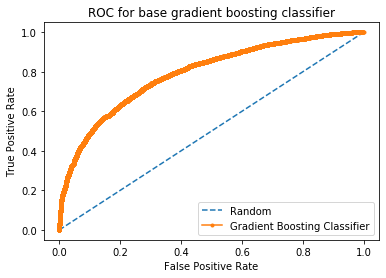

In [310]:
# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Gradient Boosting Classifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for base gradient boosting classifier')
# show the legend
plt.legend()
# show the plot
plt.show()

<div class="alert alert-info">
    <p>Though the train and test scores look good, the confusion matrix shows some prediction problems. The model contained too many false positives, meaning that the model is predicting a station will be inactive when it is actually not. This indicates a low precision rate, so further model tuning needs to be done. </p>
    <p>For hyperparameter tuning, a randomized search is performed with 100 iterations. Features such as the number of estimators, max depth, minimum samples to split on, and maximum features are searched for the optimal value.</p>
</div>

In [261]:
from sklearn.model_selection import RandomizedSearchCV 

param_test = {'n_estimators':range(20,81,10), 'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200), 
             'max_features':['sqrt', 'auto']}
rsearch1 = RandomizedSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_leaf=50,
                                                               subsample=0.8,
                                                               random_state=0), 
                        param_distributions = param_test, scoring='roc_auc',iid=False, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
rsearch1.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 896.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 1821.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=50,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                    

In [263]:
rsearch1.best_params_, rsearch1.best_score_

({'n_estimators': 50,
  'min_samples_split': 200,
  'max_features': 'auto',
  'max_depth': 15},
 0.9931827510579371)

<div class="alert alert-info">
    <p>Now that the best values have been identified, it is time to put them back into the classifier and train the tuned model on our data to determine if there is any improvement. The model is validated using cross validation, and then analyed using an roc curve, confusion matrix, precision, recall, and f-1 score. </p>
</div>

In [264]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.1, 
                                       n_estimators=50, 
                                       max_features='auto', 
                                       subsample=0.8,
                                       max_depth= 15,
                                       min_samples_split= 200,
                                       random_state=0,
                                       verbose=True)
clf_tuned.fit(X_train,y_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4261           0.0753           51.41m
         2           0.3860           0.0393           53.59m
         3           0.3538           0.0311           57.44m
         4           0.3273           0.0248           59.44m
         5           0.3063           0.0205           59.45m
         6           0.2902           0.0164           65.15m
         7           0.2736           0.0153           78.04m
         8           0.2599           0.0130           85.14m
         9           0.2471           0.0123           89.58m
        10           0.2351           0.0116           95.05m
        20           0.1565           0.0052           59.92m
        30           0.1168           0.0025           36.92m
        40           0.0941           0.0017           17.41m
        50           0.0801           0.0007            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=200,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [265]:
score = cross_val_score(clf_tuned, X, y, cv=kfold, scoring='roc_auc').mean()

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4092           0.0886           26.43m
         2           0.3666           0.0416           28.24m
         3           0.3334           0.0331           29.56m
         4           0.3080           0.0244           30.50m
         5           0.2870           0.0213           30.82m
         6           0.2685           0.0178           31.11m
         7           0.2513           0.0162           31.27m
         8           0.2367           0.0147           31.29m
         9           0.2241           0.0121           31.10m
        10           0.2129           0.0110           30.83m
        20           0.1372           0.0045           25.13m
        30           0.1002           0.0024           17.49m
        40           0.0804           0.0013            8.77m
        50           0.0689           0.0007            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
      

        30           0.1066           0.0022           18.37m
        40           0.0855           0.0012            9.19m
        50           0.0737           0.0006            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4196           0.0925           27.49m
         2           0.3761           0.0431           28.95m
         3           0.3435           0.0311           30.01m
         4           0.3181           0.0252           31.67m
         5           0.2962           0.0213           31.44m
         6           0.2793           0.0166           31.51m
         7           0.2629           0.0156           31.32m
         8           0.2480           0.0143           30.74m
         9           0.2334           0.0141           30.68m
        10           0.2214           0.0114           30.28m
        20           0.1443           0.0051           24.57m
        30           0.1051           0.0025           17.37m
       

In [269]:
print(classification_report(y_test, clf_tuned.predict(X_test)))


              precision    recall  f1-score   support

           0       0.94      0.84      0.89     17504
           1       0.99      1.00      0.99    235434

    accuracy                           0.99    252938
   macro avg       0.97      0.92      0.94    252938
weighted avg       0.98      0.99      0.98    252938



In [270]:
confusion_matrix(y_test, clf_tuned.predict(X_test))

array([[ 14662,   2842],
       [   897, 234537]])

<div class="alert alert-success">
    <p>This model shows enormous improvement! Precision and recall, and f-1 score are high for both classes, with a slightly worse performace for the inactive class. The accuracy of our model is also up to 99%! To understand the impact of the model, I will look at the ranked feature importances. This will tell us which features are most predictive of an inactive station, and thus, which features should be considered when making organizational changes to the station layout.</p>
</div>

In [279]:
# Find feature importances
feature_importance = pd.DataFrame(clf_tuned.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False, inplace=True)

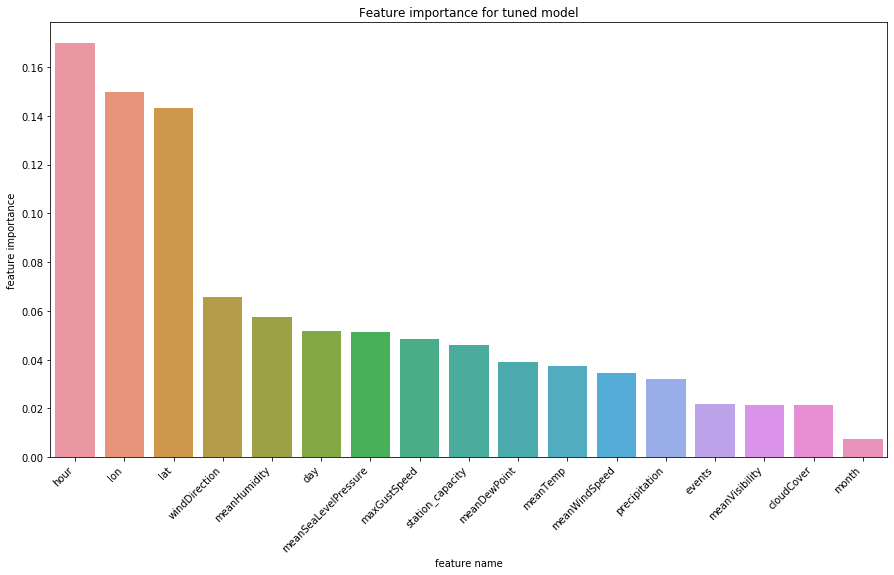

In [288]:
_ = plt.subplots(figsize=(15,8))
_ = sns.barplot(x=feature_importance.index, y='feature_importance', data=feature_importance)
_ = _.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.ylabel('feature importance')
_ = plt.xlabel('feature name')
_ = plt.title('Feature importance for tuned model')

<div class="alert alert-info">
    <p>From this graph, we can see the three most important features are hour, longitude, and latitude. Following these three, various weather features and the day of the week are seen, with month being the least significant predictor.</p>
    <ul>
        <li><b>Hour:</b>
            This is signficant, as it indicates that the time of day is the most important factor as to whether or not a station becomes inactive. In terms of actionable decisions, this could mean that Austin Bcycle replenishes stations during the most active times of day.</li>
        <li><b>Latitude and Longitude:</b>
               These two variables together represent location, which means that some areas of austin are more likely to rent a bike than others. I would suggest that either the quantity of stations be increased in these hot areas, or that the capacity of stations within these areas is increased.</li>
        <li><b>Month:</b>
            Month is probably ranked the lowest due to its low number of unique values. If the data were expanded to include months other than April and May, this variable may increase in importance for the model. i.e. I would expect summer months to have more inactive stations than winter months.
        </li>
    </ul>
</div>

No Skill: ROC AUC=0.500
GB: ROC AUC=0.995


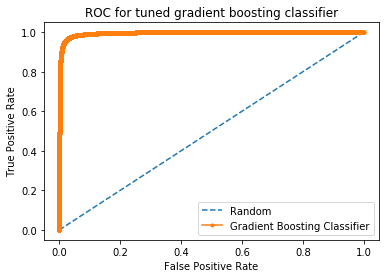

In [309]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf_tuned.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Gradient Boosting Classifier')
# axis labels
plt.title('ROC for tuned gradient boosting classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<div class="alert alert-info">
    <p>The ROC curve is excellent, with an area under the curve equal to 99.5%. </p>
</div>

<div class = 'alert alert-info'> 
    <h1> Conclusions</h1>
    <h3>Results summary:</h3>
    <ul>
<li> I began by testing seven different classifiers in order to diversify my options, but found that the gradient boosting classifier performed best at baseline. </li>
<li> My original models all seemed to perform well in terms of accuracy, with the best model having an accuracy of 93%. However, after looking into the classification report, I found the model had poor recall and f-1 scores. </li>
<li> After extensive hyperparameter tuning, not only did the model increase accuracy up to 99% (6% improvement), but the recall and f-1 statistics dramatically improved. </li>
<li> Additionally, the tuned gradient boosting classifier increased the area under the curve from 0.793 to 0.995, a 0.202 increase. </li>
<li> Evaluating the feature importances showed that the hour of day and location of the station are the most powerful predictors of inactivity. I would suggest that Austin Bcycle refill stations at the most inactive time of day, as well as look into adding additional or larger stations in highly inactive locations.</li>
    </ul>
<h3> Future directions:</h3>
<ul>
<li> Adding data from months other than April and May could introduce month as a more important predicting feature; The same could be said for year, since all of the data came from 2016.</li> 
<li> Collecting data on average ride time would be valuable in understanding if stations become inactive more frequently when rider's embark on longer routes. It would also be interesting to know if some stations are correlated with a higher average ride time than others, leading to the need for a higher station capacity in a particular location.</li>
<li> Hyperparamter tuning should be done on other high performing baseline models, but was not done here due to time constraints. </li>
<li> Further hyperparameter tuning by grid search should be done, but was not done here due to hardware limitations.</li>
    </ul>
</div>